## CS224 - Winter 2024
## HW 3: Dog Denoiser

Submit **PDF** of completed IPython notebook on **Canvas**

**Due**: March 12, 2024 @ 11:59pm PDT

**Maximum points**: 15 (each HW is %15 of total grade)

<div style="margin-bottom: 15px; padding: 15px; color: #31708f; background-color: #d9edf7; border: 1px solid #bce8f1; border-radius: 5px;">
    
<b><font size=+2>Enter your information below:</font></b></br></br>

  <b>(full) Name</b>: quiet
  </br>

  <b>Student ID Number</b>:  cutie
  </br></br>
    
<b>By submitting this notebook, I assert that the work below is my own work, completed for this course.  Except where explicitly cited, none of the portions of this notebook are duplicated from anyone else's work or my own previous work.</b>
</div>

# Overview
In this assignment, we will make a linear and nonlinear dog denoiser (inspired by the need to restore a damaged image of Sir Fluffles III to its former glory as discussed in class).
Complete all the code marked `TODO`.

### Import libraries, data, viz data
This section can remain unchanged.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
# To access the nets.py file stored in my google drive.
import sys
sys.path.append('/content/drive/MyDrive/CS224')

Using device: cuda
Example images of CIFAR-10 dogs


torch.Size([4000, 3, 32, 32])

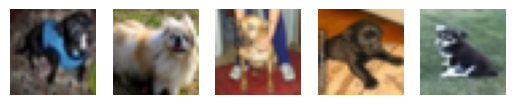

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import SGD  # Our chosen optimizer
from torch.utils.data import DataLoader, TensorDataset
from nets import UNet

def show_image(xs):
    """Display a list of CIFAR-10 images in a table.
    Images may be flattened or unflattened.
    Assumes floats in range [0,1] representing colors"""
    xs = xs.cpu()
    n = len(xs)
    fig, axs = plt.subplots(1, n)
    for i, ax in enumerate(axs):
        x = xs[i].reshape(3, 32, 32).moveaxis(0, -1)
        x = torch.clamp(x, 0., 1.)
        ax.imshow(x)
        ax.axis('off')
    return fig

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# datasets are small enough to be loaded on GPU
# usually we leave on CPU and only put the training batch on GPU
dogs_train, dogs_val = torch.load('/content/drive/MyDrive/CS224/hw3_data.pt', map_location=device)
val_loader = DataLoader(TensorDataset(dogs_val), batch_size=50, drop_last=True)

def test_model(model, val_loader=val_loader):
    """Code to test MSE on validation data."""
    criterion = nn.MSELoss()
    model.eval()
    mse = 0.
    with torch.no_grad():
        for x, in val_loader:
            x_noise = x + 0.1 * torch.randn_like(x)
            x_hat = model(x_noise).view(x.shape)
            mse += criterion(x, x_hat) / len(val_loader)
    return mse

print("Example images of CIFAR-10 dogs")
fig = show_image(dogs_train[:5])
dogs_train.shape

### Linear denoiser (6 points)

We will use PCA to define a linear denoiser.
First, we encode the data into a latent factor using the top 500 principal components, then we decode to recover a (denoised) version of the image that lies on the linear subspace spanned by the first 500 components.
I found it convenient to put a "flatten" operation inside fit and forward, so I could just input the images directly with the same shape as for the UNet.

In [20]:
class LinearDenoiser(nn.Module):
    """Denoise by projecting onto linear subspace spanned by
    top principal components."""
    def __init__(self, d=500):
        super(LinearDenoiser, self).__init__()
        self.d = d  # Number of principal components to use
        # We won't use backprop on this model,
        # so you can initialize/store parameters however you like
        self.mean = None
        self.components = None

    def forward(self, x):
        x = x.flatten(start_dim=1)  # Flatten images to vectors
        # print(x.shape)
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat

    def encode(self, x):
        # TODO [1 points]: encode x into low-d latent space
        x_centered = x - self.mean
        z = torch.mm(x_centered, self.components[:, :self.d])
        return z

    def decode(self, z):
        # TODO [1 points]: linearly decode back to x-space
        x_hat = torch.mm(z, self.components[:,:self.d].T) + self.mean
        return x_hat

    def fit(self, x):
        # TODO [4 points]: Use PCA to get the parameters
        # Don't forget to center the data and store mean
        # for reconstruction.
        # Use SVD to get eigenvectors of covariance,
        # like I did in class
        # Center the data and store mean
        # x = x.view(x.size(0), -1)
        x = x.flatten(start_dim=1)
        self.mean = torch.mean(x, dim=0)
        x_centered = x - self.mean
        # Compute covariance matrix
        cov_matrix = torch.mm(x_centered.T, x_centered) / x_centered.size(0)
        # Perform SVD to get eigenvectors
        U, S, V = torch.svd(cov_matrix)
        # Store the top d principal components
        self.components = U


linear_model = LinearDenoiser()
linear_model.fit(dogs_train)

### Train U-Net [5 points]
Use the included U-Net, and train it to denoise images
by minimizing the Mean Square Error loss (nn.MSELoss) between images and reconstructions from a noisy version of the image.
Use a noise standard deviation of 0.1.
Train with SGD.

In [26]:
# TODO [5 points]
# Train the UNet.
# This one is a little slow to train.
# I got reasonable results in 20 epochs on my laptop, in about 30 mins
# However, you might want to learn how to use cuda() on colab
# to dramatically speed this up.

from tqdm import tqdm

model = UNet().to(device)
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.MSELoss()

train_loader = DataLoader(TensorDataset(dogs_train), batch_size=50, shuffle=True)
val_loader = DataLoader(TensorDataset(dogs_val), batch_size=50, drop_last=True)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for noisy_images, in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        noisy_images += 0.1 * torch.randn_like(noisy_images) # Add noise to input images
        noisy_images = noisy_images.to(device)
        optimizer.zero_grad()
        outputs = model(noisy_images)
        loss = criterion(outputs, noisy_images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Evaluate on the validation set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for noisy_images, in val_loader:
            noisy_images += 0.1 * torch.randn_like(noisy_images)
            noisy_images = noisy_images.to(device)
            outputs = model(noisy_images)
            val_loss += criterion(outputs, noisy_images).item()
        val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss}")
print("Training complete!")

Epoch 1/50: 100%|██████████| 80/80 [00:01<00:00, 53.75it/s]


Epoch [1/50], Train Loss: 0.050065303267911074, Val Loss: 0.014584752731025219


Epoch 2/50: 100%|██████████| 80/80 [00:01<00:00, 56.78it/s]


Epoch [2/50], Train Loss: 0.013351049600169062, Val Loss: 0.011422112816944718


Epoch 3/50: 100%|██████████| 80/80 [00:01<00:00, 56.80it/s]


Epoch [3/50], Train Loss: 0.011058913834858686, Val Loss: 0.009679786581546067


Epoch 4/50: 100%|██████████| 80/80 [00:01<00:00, 54.62it/s]


Epoch [4/50], Train Loss: 0.009674622979946434, Val Loss: 0.008538793353363872


Epoch 5/50: 100%|██████████| 80/80 [00:01<00:00, 54.25it/s]


Epoch [5/50], Train Loss: 0.008747878641588613, Val Loss: 0.007837239559739828


Epoch 6/50: 100%|██████████| 80/80 [00:01<00:00, 56.21it/s]


Epoch [6/50], Train Loss: 0.008047712832922115, Val Loss: 0.007180239842273295


Epoch 7/50: 100%|██████████| 80/80 [00:01<00:00, 56.41it/s]


Epoch [7/50], Train Loss: 0.007411805877927691, Val Loss: 0.006631873757578432


Epoch 8/50: 100%|██████████| 80/80 [00:01<00:00, 56.31it/s]


Epoch [8/50], Train Loss: 0.007059379474958405, Val Loss: 0.0061444495106115935


Epoch 9/50: 100%|██████████| 80/80 [00:01<00:00, 55.93it/s]


Epoch [9/50], Train Loss: 0.006569909059908241, Val Loss: 0.0057444834848865865


Epoch 10/50: 100%|██████████| 80/80 [00:01<00:00, 56.25it/s]


Epoch [10/50], Train Loss: 0.006151315604802221, Val Loss: 0.00545780542306602


Epoch 11/50: 100%|██████████| 80/80 [00:01<00:00, 56.05it/s]


Epoch [11/50], Train Loss: 0.005708769569173456, Val Loss: 0.005121292523108422


Epoch 12/50: 100%|██████████| 80/80 [00:01<00:00, 54.13it/s]


Epoch [12/50], Train Loss: 0.00550994977238588, Val Loss: 0.004843731294386089


Epoch 13/50: 100%|██████████| 80/80 [00:01<00:00, 53.17it/s]


Epoch [13/50], Train Loss: 0.005362831958336756, Val Loss: 0.004665198549628258


Epoch 14/50: 100%|██████████| 80/80 [00:01<00:00, 55.71it/s]


Epoch [14/50], Train Loss: 0.0050014886888675395, Val Loss: 0.004477234464138747


Epoch 15/50: 100%|██████████| 80/80 [00:01<00:00, 55.62it/s]


Epoch [15/50], Train Loss: 0.004891674721147865, Val Loss: 0.004289113916456699


Epoch 16/50: 100%|██████████| 80/80 [00:01<00:00, 55.56it/s]


Epoch [16/50], Train Loss: 0.004586425417801365, Val Loss: 0.004062603646889329


Epoch 17/50: 100%|██████████| 80/80 [00:01<00:00, 55.59it/s]


Epoch [17/50], Train Loss: 0.004512557853013277, Val Loss: 0.0038777039735578


Epoch 18/50: 100%|██████████| 80/80 [00:01<00:00, 55.59it/s]


Epoch [18/50], Train Loss: 0.004281353816622868, Val Loss: 0.0037972982972860336


Epoch 19/50: 100%|██████████| 80/80 [00:01<00:00, 55.87it/s]


Epoch [19/50], Train Loss: 0.004217918423819356, Val Loss: 0.0036806759075261653


Epoch 20/50: 100%|██████████| 80/80 [00:01<00:00, 54.65it/s]


Epoch [20/50], Train Loss: 0.004143890045816079, Val Loss: 0.00348564957967028


Epoch 21/50: 100%|██████████| 80/80 [00:01<00:00, 54.18it/s]


Epoch [21/50], Train Loss: 0.004139690462034195, Val Loss: 0.0033974163117818533


Epoch 22/50: 100%|██████████| 80/80 [00:01<00:00, 55.75it/s]


Epoch [22/50], Train Loss: 0.003912999088061042, Val Loss: 0.003269716608338058


Epoch 23/50: 100%|██████████| 80/80 [00:01<00:00, 56.22it/s]


Epoch [23/50], Train Loss: 0.0037436795595567674, Val Loss: 0.0031529519357718526


Epoch 24/50: 100%|██████████| 80/80 [00:01<00:00, 56.39it/s]


Epoch [24/50], Train Loss: 0.003661107152584009, Val Loss: 0.0030959107796661558


Epoch 25/50: 100%|██████████| 80/80 [00:01<00:00, 56.45it/s]


Epoch [25/50], Train Loss: 0.003593941088183783, Val Loss: 0.0029981395695358516


Epoch 26/50: 100%|██████████| 80/80 [00:01<00:00, 56.51it/s]


Epoch [26/50], Train Loss: 0.003415241843322292, Val Loss: 0.0029317451058886944


Epoch 27/50: 100%|██████████| 80/80 [00:01<00:00, 56.26it/s]


Epoch [27/50], Train Loss: 0.0033613748470088466, Val Loss: 0.002816420840099454


Epoch 28/50: 100%|██████████| 80/80 [00:01<00:00, 55.50it/s]


Epoch [28/50], Train Loss: 0.0033251149230636655, Val Loss: 0.0027769307955168186


Epoch 29/50: 100%|██████████| 80/80 [00:01<00:00, 54.69it/s]


Epoch [29/50], Train Loss: 0.0032781155896373093, Val Loss: 0.002731896692421287


Epoch 30/50: 100%|██████████| 80/80 [00:01<00:00, 55.49it/s]


Epoch [30/50], Train Loss: 0.0032663108664564787, Val Loss: 0.0026460810098797084


Epoch 31/50: 100%|██████████| 80/80 [00:01<00:00, 56.73it/s]


Epoch [31/50], Train Loss: 0.003137088706716895, Val Loss: 0.002632740675471723


Epoch 32/50: 100%|██████████| 80/80 [00:01<00:00, 56.75it/s]


Epoch [32/50], Train Loss: 0.0030980268667917697, Val Loss: 0.0025470347376540304


Epoch 33/50: 100%|██████████| 80/80 [00:01<00:00, 57.05it/s]


Epoch [33/50], Train Loss: 0.0030886692577041684, Val Loss: 0.0026200351654551922


Epoch 34/50: 100%|██████████| 80/80 [00:01<00:00, 57.11it/s]


Epoch [34/50], Train Loss: 0.00284309301932808, Val Loss: 0.0025012064375914632


Epoch 35/50: 100%|██████████| 80/80 [00:01<00:00, 57.06it/s]


Epoch [35/50], Train Loss: 0.0028949429863132535, Val Loss: 0.002383796207141131


Epoch 36/50: 100%|██████████| 80/80 [00:01<00:00, 56.72it/s]


Epoch [36/50], Train Loss: 0.0027916088816709816, Val Loss: 0.0023582773166708646


Epoch 37/50: 100%|██████████| 80/80 [00:01<00:00, 55.38it/s]


Epoch [37/50], Train Loss: 0.002858583690249361, Val Loss: 0.0022713753744028507


Epoch 38/50: 100%|██████████| 80/80 [00:01<00:00, 55.10it/s]


Epoch [38/50], Train Loss: 0.002727336515090428, Val Loss: 0.0022943369578570126


Epoch 39/50: 100%|██████████| 80/80 [00:01<00:00, 57.54it/s]


Epoch [39/50], Train Loss: 0.0028762843110598625, Val Loss: 0.002239765750709921


Epoch 40/50: 100%|██████████| 80/80 [00:01<00:00, 56.91it/s]


Epoch [40/50], Train Loss: 0.0027484472841024397, Val Loss: 0.0021712565212510526


Epoch 41/50: 100%|██████████| 80/80 [00:01<00:00, 57.53it/s]


Epoch [41/50], Train Loss: 0.0025658673781435936, Val Loss: 0.0021368805668316782


Epoch 42/50: 100%|██████████| 80/80 [00:01<00:00, 57.02it/s]


Epoch [42/50], Train Loss: 0.002623464405769482, Val Loss: 0.0021258640452288093


Epoch 43/50: 100%|██████████| 80/80 [00:01<00:00, 57.44it/s]


Epoch [43/50], Train Loss: 0.0025002977752592416, Val Loss: 0.0020494428812526167


Epoch 44/50: 100%|██████████| 80/80 [00:01<00:00, 57.17it/s]


Epoch [44/50], Train Loss: 0.0024942932359408587, Val Loss: 0.002031299943337217


Epoch 45/50: 100%|██████████| 80/80 [00:01<00:00, 55.39it/s]


Epoch [45/50], Train Loss: 0.0025243848911486568, Val Loss: 0.002012692712014541


Epoch 46/50: 100%|██████████| 80/80 [00:01<00:00, 55.20it/s]


Epoch [46/50], Train Loss: 0.0024886649509426205, Val Loss: 0.001957775111077353


Epoch 47/50: 100%|██████████| 80/80 [00:01<00:00, 57.03it/s]


Epoch [47/50], Train Loss: 0.002482580122887157, Val Loss: 0.0019579068291932346


Epoch 48/50: 100%|██████████| 80/80 [00:01<00:00, 56.97it/s]


Epoch [48/50], Train Loss: 0.002494248999573756, Val Loss: 0.0019139491836540402


Epoch 49/50: 100%|██████████| 80/80 [00:01<00:00, 56.79it/s]


Epoch [49/50], Train Loss: 0.0023842122158384883, Val Loss: 0.0018950731784570963


Epoch 50/50: 100%|██████████| 80/80 [00:01<00:00, 56.67it/s]


Epoch [50/50], Train Loss: 0.0023122957689338365, Val Loss: 0.001874000404495746
Training complete!


###  Results [4 points]

You shouldn't need to change the code below. It just prints out denoised images and validation loss using your trained UNet and fitted Linear model.

4 points for getting correct looking results. It should be possible to get MSE below 0.01 (value for no denoising at all), and the denoised images should be noticeably better, for linear and nonlinear denoisers

Original images


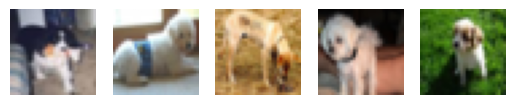

Noisy images


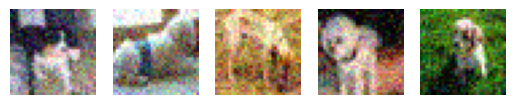

Linear denoising


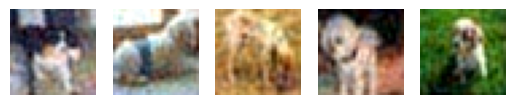

UNet denoising


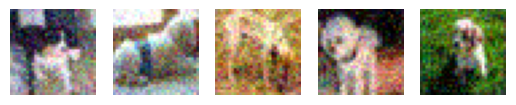

Linear model Val MSE: 0.0026
UNet Val MSE: 0.0092


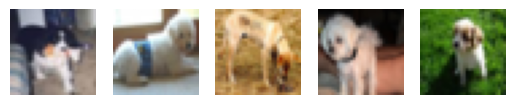

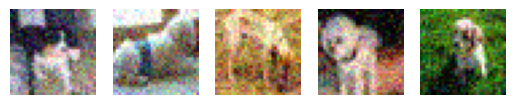

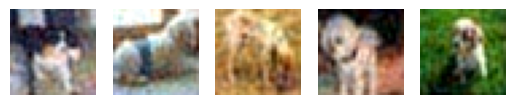

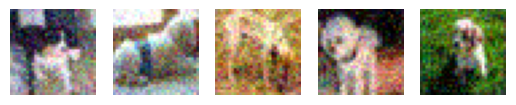

In [27]:
dogs = dogs_val[:5].cpu()
noisy_dogs = dogs + 0.1 * torch.randn_like(dogs)  # Done on CPU to avoid MPS bug!
with torch.no_grad():
    linear_denoise = linear_model(noisy_dogs.to(device)).cpu()
    unet_denoise = model(noisy_dogs.to(device)).cpu()

print("Original images")
display(show_image(dogs))
print("Noisy images")
display(show_image(noisy_dogs))
print("Linear denoising")
display(show_image(linear_denoise))
print("UNet denoising")
display(show_image(unet_denoise))

linear_mse = test_model(linear_model)
unet_mse = test_model(model)
print(f"Linear model Val MSE: {linear_mse:.4f}")
print(f"UNet Val MSE: {unet_mse:.4f}")

###  Extra credit
We won't have time for grading since we're near the end of class, so no extra credit opportunities.
There are some interesting things to explore though. What happens if you put an already denoised image through the denoiser again? If you keep repeating, will it converge to some fixed point? What happens if you put some images that differ significantly from training? For instance, will noisy cats get turned into dogs? If we put pure Gaussian noise in, will we eventually get something dog-like?


Original Noisy Images


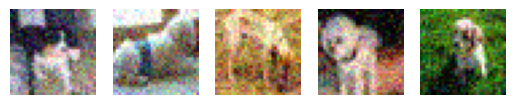

Original Denoised Images


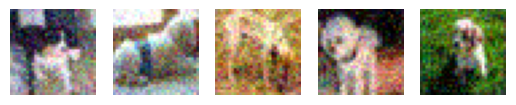

Images after 5 Iterations of Repeated Denoising


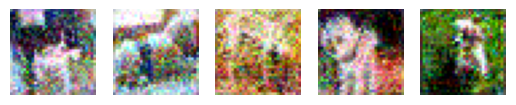

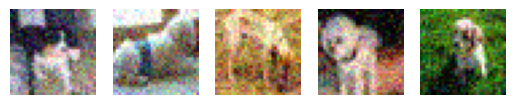

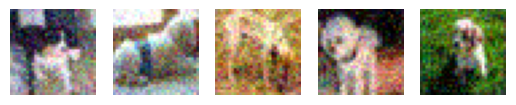

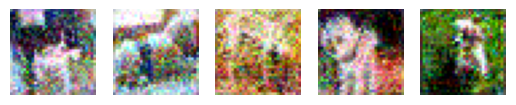

In [28]:
import torch
def repeated_denoising(model, images, num_iterations):
    denoised_images = images.clone()  # cloning images

    for _ in range(num_iterations):
        with torch.no_grad():
            denoised_images = model(denoised_images.to(device)).cpu()

    return denoised_images

num_iterations = 5
denoised_images_repeated = repeated_denoising(model, noisy_dogs, num_iterations)

print("Original Noisy Images")
display(show_image(noisy_dogs))
print("Original Denoised Images")
display(show_image(unet_denoise))
print(f"Images after {num_iterations} Iterations of Repeated Denoising")
display(show_image(denoised_images_repeated))
